<a href="https://colab.research.google.com/github/Rey-Morales-G/Alura_Telecom_X_2/blob/main/Alura_TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Data Preparation
We start by dropping irrelevant features and preparing the dataset for the algorithms.

Data Loading & Flattening

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
url= "https://raw.githubusercontent.com/Rey-Morales-G/Alura_Telecom_X/main/TelecomX_Data.json"
df_raw= pd.read_json(url)

#Quick check
df_raw.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [3]:
# Flatten the nested columns (customer, phone, internet, account)
# This expands the dictionaries into individual columns
df_customer = pd.json_normalize(df_raw['customer'])
df_phone = pd.json_normalize(df_raw['phone'])
df_internet = pd.json_normalize(df_raw['internet'])
df_account = pd.json_normalize(df_raw['account'])

# Combine everything back into one dataframe, dropping the old nested columns
df = pd.concat([df_raw[['customerID', 'Churn']], df_customer, df_phone, df_internet, df_account], axis=1)

# Quick check to ensure columns are now flat
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


Preparation & Encoding

remove the ID, encode variables, and check balance.

In [4]:
# Remove unique identifiers
df_clean = df.drop(columns=['customerID'], errors='ignore')

# Encode categorical variables (One-Hot Encoding)
df_final = pd.get_dummies(df_clean, drop_first=True)

# Check Class Balance
print("Churn Proportion:")
print(df_final['Churn_Yes'].value_counts(normalize=True))

# Balance with SMOTE
X = df_final.drop('Churn_Yes', axis=1)
y = df_final['Churn_Yes']

smt = SMOTE(random_state=42)
X_res, y_res = smt.fit_resample(X, y)

print(f"Original dataset shape: {y.shape}")
print(f"Balanced dataset shape: {y_res.shape}")

Churn Proportion:
Churn_Yes
False    0.74281
True     0.25719
Name: proportion, dtype: float64
Original dataset shape: (7267,)
Balanced dataset shape: (10796,)


Correlation and Feature Selection
Visualizing relationships helps justify why we choose certain variables for the model.

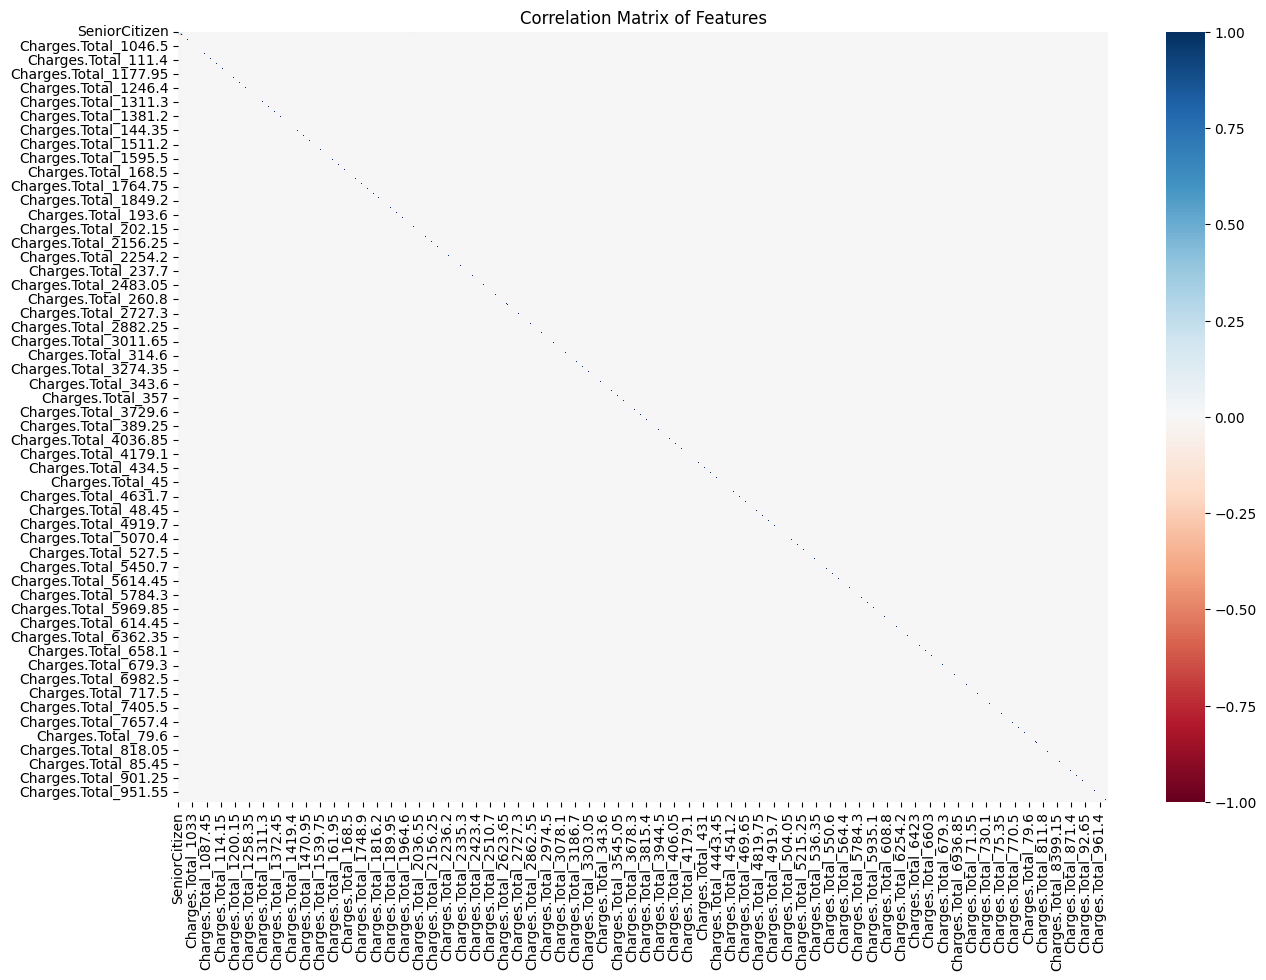

In [5]:
# Correlation Matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df_final.corr(), annot=False, cmap='RdBu')
plt.title("Correlation Matrix of Features")
plt.show()

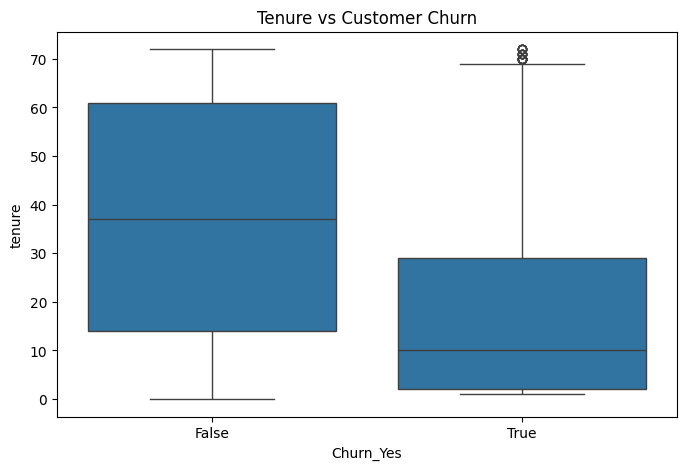

In [6]:
# Relationship: Contract Time vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn_Yes', y='tenure', data=df_final)
plt.title("Tenure vs Customer Churn")
plt.show()

Predictive Models
I will compare KNN (Distance-based) and Random Forest (Tree-based).

In [7]:
# Data Splitting (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Model 1: KNN (Requires Normalization)
# Scaling ensures that 'MonthlyCharges' doesn't outweigh 'Tenure' just because of its magnitude
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Model 2: Random Forest (No Normalization required)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

metrics needed for  report (Accuracy, Precision, Recall, F1)

KNN Results:
               precision    recall  f1-score   support

       False       0.81      0.97      0.88      1060
        True       0.96      0.78      0.86      1100

    accuracy                           0.87      2160
   macro avg       0.89      0.87      0.87      2160
weighted avg       0.89      0.87      0.87      2160

Random Forest Results:
               precision    recall  f1-score   support

       False       0.98      0.97      0.98      1060
        True       0.97      0.99      0.98      1100

    accuracy                           0.98      2160
   macro avg       0.98      0.98      0.98      2160
weighted avg       0.98      0.98      0.98      2160



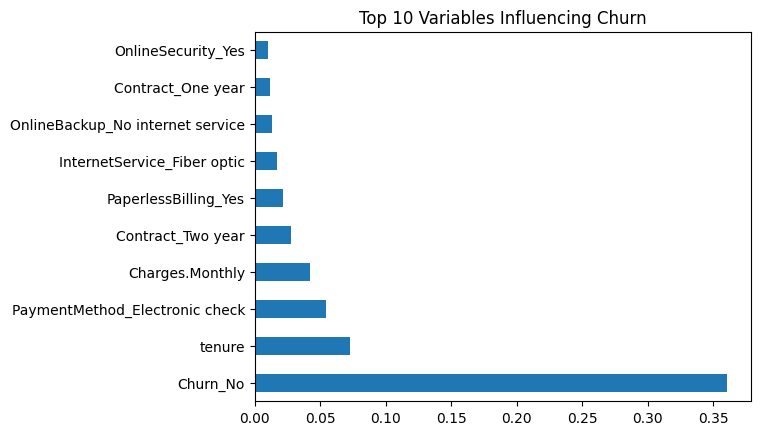

In [8]:
from sklearn.metrics import classification_report

print("KNN Results:\n", classification_report(y_test, y_pred_knn))
print("Random Forest Results:\n", classification_report(y_test, y_pred_rf))

# Identify most important variables for the report
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Variables Influencing Churn")
plt.show()